In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import ndtr
from scipy.optimize import curve_fit
from scipy.stats import linregress
from pathlib import Path
from math import log, sqrt, e
import json

# 2. HUMANS:

## 2.1: global pooling

- N=300

In [3]:
# creating empty dataframe:
humans_300_complete_df = pd.DataFrame()
# accessing all json files in 'data' directory:
files = Path('./data/').glob('*.json')
file_counter = 0
for file in files:
    # reading single json file as dataframe
    df = pd.read_json(file)
    # adding single dataframe to general dataframe:
    humans_300_complete_df = pd.concat([humans_300_complete_df,df])
    # incrementing file counter (will be used to label the graph):
    file_counter += 1
    print(file_counter)

1
2


In [50]:
humans_300_complete_df

,success,timeout,failed_images,failed_audio,failed_video,trial_type,trial_index,time_elapsed,internal_node_id,view_history,...,stimulus,response,nodes_order,correct_response,block_index,presentation_index,clique_size,graph_size,graphs_couple,correct
0,1.0,0.0,[],[],[],preload,0,77,0.0-0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,instructions,1,2312,0.0-1.0,"[{'page_index': 0, 'viewing_time': 1457}, {'pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,[],[],[],preload,2,2585,0.0-2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,instructions,3,11455,0.0-3.0,"[{'page_index': 0, 'viewing_time': 954}, {'pag...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,instructions,4,11873,0.0-4.0,"[{'page_index': 0, 'viewing_time': 418}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,NaN,NaN,NaN,NaN,NaN,audio-keyboard-response,105,90983,0.0-77.0-0.0-1.0,NaN,...,audio_feedback/wrong/error01.mp3,None,NaN,NaN,0.0,28.0,33.0,1000.0,"[0096_N1000_K0033_CLIQUE, 0071_N1000_K0033_NOC...",NaN
106,NaN,NaN,NaN,NaN,NaN,canvas-keyboard-response,106,91934,0.0-78.0-0.0-0.0,NaN,...,NaN,arrowright,"[491, 340, 262, 816, 454, 559, 558, 410, 47, 4...",arrowleft,0.0,29.0,33.0,1000.0,"[0026_N1000_K0033_CLIQUE, 0030_N1000_K0033_NOC...",0.0
107,NaN,NaN,NaN,NaN,NaN,audio-keyboard-response,107,92923,0.0-78.0-0.0-1.0,NaN,...,audio_feedback/wrong/error01.mp3,None,NaN,NaN,0.0,29.0,33.0,1000.0,"[0026_N1000_K0033_CLIQUE, 0030_N1000_K0033_NOC...",NaN
108,NaN,NaN,NaN,NaN,NaN,instructions,108,95742,0.0-79.0,"[{'page_index': 0, 'viewing_time': 2817}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# isolating survey trials and calculating average age:
humans_300_survey = humans_300_complete_df[humans_300_complete_df.trial_type == "survey-html-form"].response
ages_list = []
for i in humans_300_survey:
    ages_list.append(int(i['age']))

# printing age list and average age:
print(ages_list)
print(np.mean(ages_list))


[23, 34]
28.5


In [6]:
# isolating experiment trials ("canvas-keyboard-response" ones) and dropping irrelevant variables:
humans_300_cleaned = humans_300_complete_df[humans_300_complete_df.trial_type == "canvas-keyboard-response"]
# dropping irrelevant variables:
humans_300_cleaned.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus"], axis=1, inplace=True)

# isolating trials were final responses were given (shuffles have " " as response):
humans_300_final = humans_300_cleaned[humans_300_cleaned['response'].isin(['arrowright','arrowleft'])]
print(humans_300_final['clique_size'].value_counts() )  # final answers for each clique size should be 12*(number of participants)


300.0    4
267.0    4
233.0    4
217.0    4
200.0    4
183.0    4
167.0    4
150.0    4
133.0    4
117.0    4
100.0    4
83.0     4
67.0     4
50.0     4
33.0     4
Name: clique_size, dtype: int64


C:\Users\danie\AppData\Local\Temp\ipykernel_3768\1383728850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humans_300_cleaned.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus"], axis=1, inplace=True)


In [10]:
# loop through trials to retrieve graph names:
for clique_size in humans_300_final['clique_size'].unique():
    # isolating data of current clique size:
    current_data = humans_300_final[humans_300_final.clique_size == clique_size]
    # counting number of trials for current clique size:
    print(type(current_data.graphs_couple))
    # unpacking the series:
    for i in current_data.graphs_couple:
        print(i)
        print(i[1])

<class 'pandas.core.series.Series'>
['0037_N1000_K0300_NOCLIQUE', '0073_N1000_K0300_CLIQUE']
0073_N1000_K0300_CLIQUE
['0069_N1000_K0300_NOCLIQUE', '0055_N1000_K0300_CLIQUE']
0055_N1000_K0300_CLIQUE
['0058_N1000_K0300_NOCLIQUE', '0096_N1000_K0300_CLIQUE']
0096_N1000_K0300_CLIQUE
['0026_N1000_K0300_NOCLIQUE', '0007_N1000_K0300_CLIQUE']
0007_N1000_K0300_CLIQUE
<class 'pandas.core.series.Series'>
['0051_N1000_K0267_NOCLIQUE', '0034_N1000_K0267_CLIQUE']
0034_N1000_K0267_CLIQUE
['0077_N1000_K0267_CLIQUE', '0060_N1000_K0267_NOCLIQUE']
0060_N1000_K0267_NOCLIQUE
['0040_N1000_K0267_NOCLIQUE', '0089_N1000_K0267_CLIQUE']
0089_N1000_K0267_CLIQUE
['0002_N1000_K0267_NOCLIQUE', '0082_N1000_K0267_CLIQUE']
0082_N1000_K0267_CLIQUE
<class 'pandas.core.series.Series'>
['0086_N1000_K0233_NOCLIQUE', '0080_N1000_K0233_CLIQUE']
0080_N1000_K0233_CLIQUE
['0088_N1000_K0233_NOCLIQUE', '0036_N1000_K0233_CLIQUE']
0036_N1000_K0233_CLIQUE
['0095_N1000_K0233_CLIQUE', '0010_N1000_K0233_NOCLIQUE']
0010_N1000_K0233_NOCLIQ

(TO ADAPT FROM HERE ON)

In [12]:
# CREATING DATAFRAME FOR N=300
df_humans_300_appended = []
K_range = humans_300_final['clique_size'].unique()
K_range
for index in K_range:
    # isolating data of current clique size:
    current_data = humans_300_final[humans_300_final.clique_size == index]
    # calculating accuracy for current clique size (accuracy, when present, is either True or False)
    fraction_correct_current_clique_size = sum(current_data.accuracy) / sum(~ current_data.accuracy.isna())
    df_humans_300_appended.append(pd.DataFrame({'N':[300], 'K':[index], 'fc':[fraction_correct_current_clique_size]}))
    
# creating single df for humans:    
df_humans_300 = pd.concat(df_humans_300_appended)
# creating new variable and adding it to the dataframe:
df_humans_300['K/sqrt(N)'] = df_humans_300['K']/np.sqrt(df_humans_300['N'])
# creating new variable and adding it to the dataframe:
df_humans_300['K/N'] = df_humans_300['K']/df_humans_300['N']
df_humans_300

,N,K,fc,K/sqrt(N),K/N
0,300,90.0,0.972222,5.196152,0.300000
0,300,80.0,0.966667,4.618802,0.266667
0,300,70.0,0.944444,4.041452,0.233333
0,300,65.0,0.905556,3.752777,0.216667
0,300,60.0,0.850000,3.464102,0.200000
0,300,55.0,0.788889,3.175426,0.183333
0,300,50.0,0.722222,2.886751,0.166667
0,300,45.0,0.700000,2.598076,0.150000
0,300,40.0,0.644444,2.309401,0.133333
0,300,35.0,0.538889,2.020726,0.116667


* N=1000

In [13]:
# creating empty dataframe:
humans_1000_complete_df = pd.DataFrame()
# accessing all json files in 'data' directory:
files = Path('./N_1000/data/').glob('*.csv')
file_counter = 0
for file in files:
    # reading single csv file as dataframe
    df = pd.read_csv(file)
    # adding single dataframe to general dataframe:
    humans_1000_complete_df = pd.concat([humans_1000_complete_df,df])
    # incrementing file counter (will be used to label the graph):
    file_counter += 1
    print(file_counter)

# isolating experiment trials ("canvas-keyboard-response" ones) and dropping irrelevant variables:
humans_1000_cleaned = humans_1000_complete_df[humans_1000_complete_df.trial_type == "canvas-keyboard-response"]
print("number of variables before cleaning: " + str(humans_1000_cleaned.shape[1]))
# dropping irrelevant variables:
humans_1000_cleaned.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus","graphs_couple"], axis=1, inplace=True)
# checking that cleaning happened successfully:
print("number of variables after cleaning: " + str(humans_1000_cleaned.shape[1]))

# isolating trials were final responses were given (shuffles have " " as response):
humans_1000_final = humans_1000_cleaned[humans_1000_cleaned['response'].isin(['arrowright','arrowleft'])]
print(humans_1000_final.shape)    # should be 180*(number of participants)
print(humans_1000_final['clique_size'].value_counts() )  # final answers for each clique size should be 12*(number of participants)


1
2
3
4


5
6
7
8
9
10
11
12
13
14
15
number of variables before cleaning: 22
number of variables after cleaning: 11
(2700, 11)
300.0    180
267.0    180
233.0    180
217.0    180
200.0    180
183.0    180
167.0    180
150.0    180
133.0    180
117.0    180
100.0    180
83.0     180
67.0     180
50.0     180
33.0     180
Name: clique_size, dtype: int64


C:\Users\danie\AppData\Local\Temp\ipykernel_8128\1449456132.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humans_1000_cleaned.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus","graphs_couple"], axis=1, inplace=True)


In [14]:
# CREATING DATAFRAME FOR N=1000
df_humans_1000_appended = []
K_range = humans_1000_final['clique_size'].unique()
K_range
for index in K_range:
    # isolating data of current clique size:
    current_data = humans_1000_final[humans_1000_final.clique_size == index]
    # calculating accuracy for current clique size (accuracy, when present, is either True or False)
    fraction_correct_current_clique_size = sum(current_data.accuracy == True) / sum(~ current_data.accuracy.isna())
    df_humans_1000_appended.append(pd.DataFrame({'N':[1000], 'K':[index], 'fc':[fraction_correct_current_clique_size]}))
    
# creating single df for humans:    
df_humans_1000 = pd.concat(df_humans_1000_appended)
# creating new variable and adding it to the dataframe:
df_humans_1000['K/sqrt(N)'] = df_humans_1000['K']/np.sqrt(df_humans_1000['N'])
# creating new variable and adding it to the dataframe:
df_humans_1000['K/N'] = df_humans_1000['K']/df_humans_1000['N']
df_humans_1000

,N,K,fc,K/sqrt(N),K/N
0,1000,300.0,0.988889,9.486833,0.300
0,1000,267.0,0.994444,8.443281,0.267
0,1000,233.0,0.994444,7.368107,0.233
0,1000,217.0,0.988889,6.862143,0.217
0,1000,200.0,0.994444,6.324555,0.200
0,1000,183.0,0.977778,5.786968,0.183
0,1000,167.0,0.955556,5.281004,0.167
0,1000,150.0,0.944444,4.743416,0.150
0,1000,133.0,0.900000,4.205829,0.133
0,1000,117.0,0.822222,3.699865,0.117


Joining N=300 and N=1000 data:

In [15]:
# creating single dataframe for human data:
df_humans = pd.concat([df_humans_300,df_humans_1000])
df_humans

,N,K,fc,K/sqrt(N),K/N
0,300,90.0,0.972222,5.196152,0.300000
0,300,80.0,0.966667,4.618802,0.266667
0,300,70.0,0.944444,4.041452,0.233333
0,300,65.0,0.905556,3.752777,0.216667
0,300,60.0,0.850000,3.464102,0.200000
0,300,55.0,0.788889,3.175426,0.183333
0,300,50.0,0.722222,2.886751,0.166667
0,300,45.0,0.700000,2.598076,0.150000
0,300,40.0,0.644444,2.309401,0.133333
0,300,35.0,0.538889,2.020726,0.116667


In [16]:
# FITTING THE HUMAN DATA:
# defining the sigmoid function to fit to the data:
def sigmoid(k, k0, delta):
    return (1+ndtr((k-k0)/delta))/2
# fitting the data to the sigmoid function:
fitted_params_humans = []
for N in [300,1000]:
    data_for_fit = df_humans[df_humans['N']==N]
    fitted_params_humans.append(curve_fit(sigmoid, data_for_fit['K'], data_for_fit['fc'], p0=(70, 20))[0])
fitted_params_humans = np.array(fitted_params_humans)
fitted_params_humans

array([[ 51.49224733,  15.48359133],
       [105.04469551,  41.38824887]])

In [17]:
# Creating dataframe of fitted parameters:
df_humans_fitted_params = pd.DataFrame(columns=['N', 'K0', 'Delta'])
dfs = []
# Loop through the array and populate the dataframe
for i in range(fitted_params_humans.shape[0]):
    N = [300,1000][i]
    K0_value = fitted_params_humans[i, 0]
    delta_value = fitted_params_humans[i, 1]
    df = pd.DataFrame({'N': [N], 'K0': [K0_value], 'Delta': [delta_value]})
    dfs.append(df)
df_humans_fitted_params = pd.concat(dfs, ignore_index=True)
df_humans_fitted_params

,N,K0,Delta
0,300,51.492247,15.483591
1,1000,105.044696,41.388249


(-0.05, 0.32)

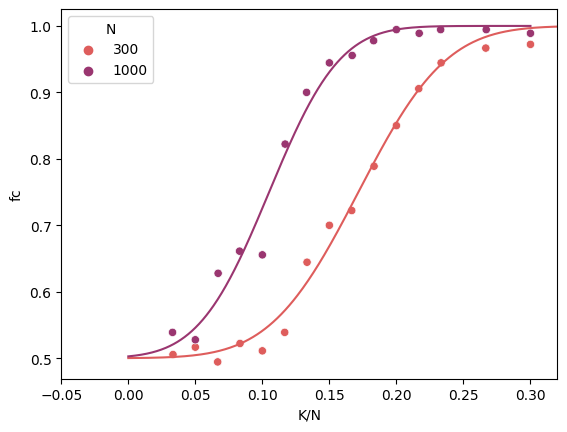

In [18]:
# plotting the sigmoid functions in the graph:
x_vals = np.linspace(0, 300, 1000)
# creating palette for the graph:
my_palette_humans = sns.color_palette("flare", fitted_params_humans.shape[0])
ax = sns.scatterplot(data=df_humans, x='K/N', y='fc', hue='N', palette=my_palette_humans)
# defining y values for each N value and plotting it:
for index in range(fitted_params_humans.shape[0]):
    N=[300, 1000][index]
    y_vals = (1+ndtr((x_vals-fitted_params_humans[index][0])/fitted_params_humans[index][1]))/2
    ax.plot(x_vals/N, y_vals, color=my_palette_humans[index])
ax.set_xlim(ax.get_xlim()[0], 0.32)

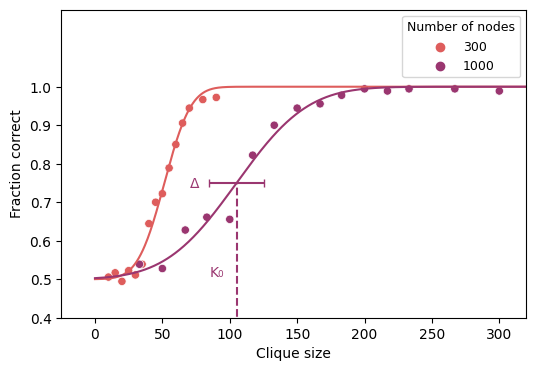

In [19]:
# HUMAN PSYCHOMETRICS GRAPH:
# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(6,4))
# plotting the sigmoid functions in the graph:
x_vals = np.linspace(0, 500, 1000)
# creating palette for the graph:
my_palette = sns.color_palette("flare", fitted_params_humans.shape[0])
ax = sns.scatterplot(data=df_humans, x='K', y='fc', hue='N', palette=my_palette)
# defining y values for each N value and plotting it:
for index in range(fitted_params_humans.shape[0]):
    y_vals = (1+ndtr((x_vals-fitted_params_humans[index][0])/fitted_params_humans[index][1]))/2
    ax.plot(x_vals, y_vals, color=my_palette[index], linewidth=1.5)
# setting labels and title:
ax.set_xlim(ax.get_xlim()[0], 320)
ax.set_ylim(0.45,1.2)
ax.set_ylabel("Fraction correct")
ax.set_xlabel("Clique size")
# increase size of tick params:
ax.tick_params(axis='x')
ax.tick_params(axis='y')
# Remove y ticks from that have no meaning:
yticks = ax.get_yticks()
yticks = [tick for tick in yticks if tick <= 1]
ax.set_yticks(yticks)
# Change legend name to "number of nodes":
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title="Number of nodes", loc='upper right', fontsize=9)
legend.get_title().set_fontsize(9)
# Find intersection point between vertical line and curve:
line_x = fitted_params_humans[1][0]
line_color = my_palette[1]
y_vals = (1 + ndtr((x_vals - fitted_params_humans[1][0]) / fitted_params_humans[1][1])) / 2
line_y = np.interp(line_x, x_vals, y_vals)
# Draw vertical dashed line that stops at the curve:
ax.plot([line_x, line_x], [0, line_y], color=line_color, linestyle='--', label='K0')
# Add label "K0" next to the vertical line:
ax.text(85, 0.5, 'K₀', color=line_color, ha='left', va='bottom')
# Add horizontal error bar:
delta_bar_width = fitted_params_humans[1][1]
ax.errorbar(line_x, line_y, xerr=delta_bar_width/2, color=line_color, capsize=3)
# Add label "delta" next to the vertical line:
ax.text(70, 0.73, r'$\Delta$', color=line_color, ha='left', va='bottom')

# saving figure in folder "figures" with 300dpi:
fig.savefig('./figures/human_psychometrics.png', dpi=300)


--------------------------------------------

Theoretical limits:

C:\Users\danie\AppData\Local\Temp\ipykernel_8128\3458022039.py:4: RuntimeWarning: divide by zero encountered in log2
  K_it = 2 * np.log2(N)


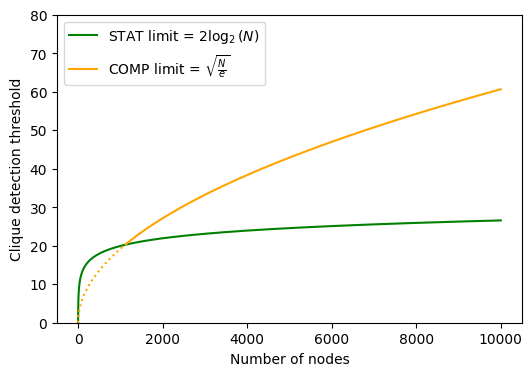

In [20]:
# Generate N values from 0 to 3000
N = np.arange(0, 10000)
# Y values for STATISTICAL LIMIT: 2 * log2(N)
K_it = 2 * np.log2(N)
# Y values for COMPUTATIONAL LIMIT:: sqrt(N / e)
K_comp = np.sqrt(N / e)
# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(6, 4))
# creating palette for the graph:
my_palette_limits = ['green','orange']
# Create the plot
ax.plot(N, K_it, label='STAT limit = $2\\log_2(N)$', color=my_palette_limits[0])
# values from 0 to 1150:
ax.plot(N[:1150], K_comp[:1150], label='COMP limit = $\\sqrt{\\frac{N}{e}}$', color=my_palette_limits[1], linestyle='dotted')
# values from 1150 to 1000:
ax.plot(N[1150:], K_comp[1150:], label='COMP limit = $\\sqrt{\\frac{N}{e}}$', color=my_palette_limits[1])
# Add labels and title to the plot
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Clique detection threshold')
# increase size of tick params:
ax.tick_params(axis='x')
ax.tick_params(axis='y')
# Set the y-axis limits to include 80
ax.set_ylim(bottom=0, top=80)
# put legend on top-left:
handles = [ax.lines[0], ax.lines[2]]
labels = [h.get_label() for h in handles]
legend = ax.legend(handles, labels, loc='upper left')
# Save plot as high resolution png:
plt.savefig('./figures/stat_comp_gap.svg', dpi=300)
# Show the plot
plt.show()

GRAPH FOR COMPARISON HUMANS - MACHINES - THEORETICAL LIMITS:

C:\Users\danie\AppData\Local\Temp\ipykernel_8128\2682020148.py:16: RuntimeWarning: divide by zero encountered in log2
  K_it = 2 * np.log2(N)


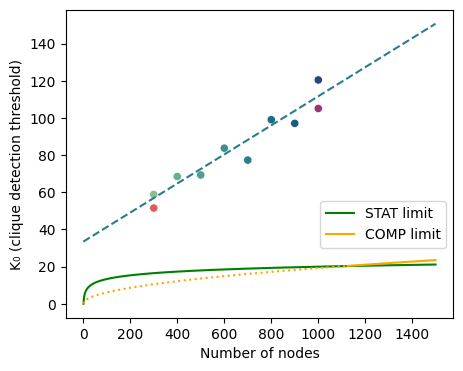

In [24]:
# Create a smaller figure with specified size
fig, ax = plt.subplots(figsize=(5,4))

# MACHINES:
# plotting K0 as a function of N (keeping the previous color coding):
ax_machines = sns.scatterplot(data=df_machines_fitted_params, x='N', y='K0', hue='N', palette=my_palette_machines, legend=False)

# HUMANS:
# plotting K0 as a function of N (keeping the previous color coding):
ax_humans = sns.scatterplot(data=df_humans_fitted_params, x='N', y='K0', hue='N', palette=my_palette_humans, legend=False)

# THEORETICAL AND COMPUTATIONAL LIMITS:
# Generate N values from 0 to 3000
N = np.arange(0, 1500)
# Y values for STATISTICAL LIMIT: 2 * log2(N)
K_it = 2 * np.log2(N)
# Y values for COMPUTATIONAL LIMIT:: sqrt(N / e)
K_comp = np.sqrt(N / e)
# creating palette for the graph:
my_palette_limits =  ['green','orange']
# Create the plot
ax.plot(N, K_it, label='STAT limit', color=my_palette_limits[0])
# values from 0 to 1125:
ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=my_palette_limits[1], linestyle='dotted')
# values from 1125 to 10000:
ax.plot(N[1125:], K_comp[1125:], label='COMP limit', color=my_palette_limits[1])
# put legend on top-left:
handles = [ax.lines[0], ax.lines[2]]
labels = [h.get_label() for h in handles]
legend = ax.legend(handles, labels, bbox_to_anchor=(1, 0.4))
# Add labels and title to the plot
ax.set_xlabel('Number of nodes')
ax.set_ylabel('K₀ (clique detection threshold)')
# increase size of tick params:
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# drawing linear fit of machines'K0s with points' color gradient
y_values = slope * N + intercept
ax.plot(N, y_values, color=my_palette_machines[4], linestyle='--') #using intermediate color of machines

# Save plot as high resolution png:
plt.savefig('./figures/comparison_graph.png', dpi=300)
# Show the plot
plt.show()

## 2.2: subject-wise analysis